# MedFoes & Degree-Day Summary Figures
MedFoes input data file created by `Parse longrun output` notebook

In [1]:
import sys
import os
import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
from mpl_toolkits.basemap import Basemap

import pandas as pd
import dateutil
from scipy import __version__ as scipy_version
import scipy.interpolate
import scipy.stats

from statsmodels import __version__ as statsmodels_version
import statsmodels.formula.api as smformula

from collections import OrderedDict

from IPython.display import display, HTML
%matplotlib notebook
plt.style.use('seaborn-paper')

print(sys.version)
print('pandas',pd.__version__)
print('numpy', np.__version__)
print('scipy', scipy_version)
print('statsmodels', statsmodels_version)
print('matplotlib', mpl.__version__)

3.5.2 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
pandas 0.19.2
numpy 1.11.3
scipy 0.18.1
statsmodels 0.6.1
matplotlib 2.0.0


### Load temperature & DD functions from another file

In [2]:
%run "Temperature functions.ipynb"

## Load site information
was created by 'Temperature datasets summary.ipynb' from isd_history.txt

In [3]:
siteinfo = pd.read_csv('stations_summary.csv', index_col='CALL')

### Constants

In [4]:
RUNSETS = [
           ['KSFO','-08:00', '1950-01-01','2016-01-01'],#
           ['KFAT','-08:00', '1950-01-01','2016-01-01'],#
           ['KBUR','-08:00', '1973-01-01','2016-01-01'],#
           ['KLAX','-08:00', '1950-01-01','2016-01-01'],#
           ['KRIV','-08:00', '1950-01-01','2016-01-01'],#
           ['KSAN','-08:00', '1950-01-01','2016-01-01'],#
           ['KJAX','-05:00', '1950-01-01','2016-01-01'],#
           ['KIAH','-06:00', '1970-01-01','2016-01-01'],#
           ['KMCO','-05:00', '1973-01-01','2016-01-01'],#
           ['KTPA','-05:00', '1950-01-01','2016-01-01'],#
           ['KMIA','-05:00', '1950-01-01','2016-01-01'],#
          ]

# the way subplots are ordered by default is different from what we want
RUNSET_IDX_2_PLOT_IDX = [0, 2, 4, 6, 8, 10, 3, 5, 7, 9, 11]

DATADIR = '../data/'
DATA_OUT_FILENAME_PAT = '{}_collated_data_out.npz' # fomatted with RUNSET
FIGDIR = '../figs/'

INTERPOLATION_METHOD = 'nearest'

CONTOUR_LEVELS = [0.05]#, 0.95] # None for off
CONTOUR_COLORS = ['w']#, 'k']

# could potentially be read from configuration
TEMPERATURE_FILENAME = 'temperature_file.csv'
STEP_SIZE = 24*7  # Each step is one week
RUNS_PER_STEP = 2500

## for degree-day computation
PLOT_DD = True
# values from Nick's "Ceratitis capitata- Review of Degree Day Models" (2011): USDA Medfly Action Plan values
# Also values used in CDFA regs sec 3406: https://www.cdfa.ca.gov/plant/medfly/docs/regs/3406-TXT-medfly.pdf
# original source appears to be:
#    Tassan, R. L., K. S. Hagen, A. Cheng, T. K. Palmer, G. Feliciano and T. L. Bough. 1982. 
#    Mediterranean fruit fly life cycle estimations for the California eradication program. 
#    CEC/IOBC Symposium Athens November 1982. pp. 564-570
DD_BASE_TEMP = tempF2C(54.3)
GEN_DD = 622*5/9 # generation time in cumulative degree days
NUM_GENS = 3 # number of generations until 'called'

dummy_year = 2011 # just any arbitary non-leapyear year for doing day-of-year

## Functions

In [5]:
def load_temperatures(runset, sitetz):
    ## Load Temperature data
    tfile = os.path.join(DATADIR, 'temperatures', '{}_AT_cleaned_trimmed.csv'.format(runset))
    tempdf = pd.read_csv(tfile, index_col='datetime', parse_dates=True)
    # Convert the times to localtime at the location... Solar time would be better, but this is good enough
    tempdf.index = tempdf.index.tz_localize('UTC').tz_convert(sitetz)
    return tempdf

# tempdf = load_temperatures(RUNSET)

In [6]:
def calculate_DDs(tempdf, dd_base_temp, dd_threshold):
    ## Calculate DD and crossings

    # simple summation of hourly readings method
    sumdd = compute_summation_DD_from_hourly_df(tempdf,
                                        base_temp=DD_BASE_TEMP,
                                        dd_threshold=GEN_DD*NUM_GENS)
    # Single triangle method
    tridd = compute_single_triangle_DD_from_hourly_df(tempdf,
                                        base_temp=DD_BASE_TEMP,
                                        dd_threshold=GEN_DD*NUM_GENS)
    # BM (single sine) method
    bmdd = compute_BM_DD_from_hourly_df(tempdf,
                                        base_temp=DD_BASE_TEMP,
                                        dd_threshold=GEN_DD*NUM_GENS)
    return sumdd, tridd, bmdd

# sumdd, tridd, bmdd = calculate_DDs(tempdf, DD_BASE_TEMP, GEN_DD*NUM_GENS)

In [7]:
def load_medfoes_results(data_filename, sitetz):
    ## Load and parse the MedFoes data (compute pe95)

    # load the MedFoes data
    tmp = np.load(data_filename)
    runset_name = tmp['runset_name']
    max_run_length = tmp['max_run_length']
    run_hours = np.arange(0,max_run_length,24)
    prop_extinct = tmp['prop_extinct'].item()

    # ...unfortunately surface plots want equally spaced data on X
    runset_starts = [] # just convience
    z = []
    pe95 = [] # storage for the 95% extripation values
    for runset_start in sorted(prop_extinct.keys()):
        pe = prop_extinct[runset_start]
        if len(pe) < 2:
            print("WARNING: too little data for set starting on", runset_start)
            break
        runset_starts.append(runset_start)
        # add a tiny bit to the final ext time so interpolation falls within
        pe[-2,0] = pe[-2,0]+np.spacing(pe[-2,0]) # add epsilon
        # iterpolate
        prop_ex_interp = scipy.interpolate.interp1d(pe[:,0], 
                                                    pe[:,1], 
                                                    kind=INTERPOLATION_METHOD, 
                                                    fill_value=(0,1), #np.nan, 
                                                    bounds_error=False)(run_hours)
        z.append([])
        z[-1] = prop_ex_interp
        # go ahead and compute 95% extirpation values too
        pe95.append(scipy.interpolate.interp1d(pe[:,1], pe[:,0], kind='linear')(0.95).item())

    z = (1-np.array(z)) # proportion persisting

    # make a nice dataframe
    ppdf = pd.DataFrame(data=z, index=runset_starts, columns=run_hours/24)

    # convert the timezone of the index to local for the site
    ppdf.index = ppdf.index.tz_localize('UTC').tz_convert(sitetz)

    # make pe95 a Series
    pe95 = pd.Series(data=pe95, index=ppdf.index)

    return ppdf, pe95

#ppdf, pe95 = load_medfoes_results(DATA_OUT_FILENAME_PAT.format(RUNSET), sitetz)

# Site locations figure
just uses values from 'station_summary.csv' file generated by `Temperature datasets summary.ipynb`

<IPython.core.display.Javascript object>


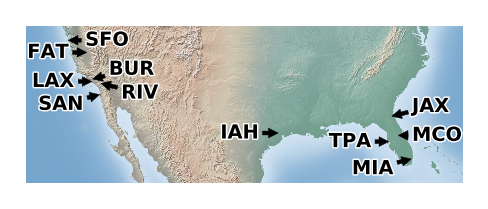

/home/travc/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/travc/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


In [8]:
fig = plt.figure(figsize=[3.5,1.5])
ax = fig.add_subplot(1,1,1)

# make the Basemap object which handles all the projection stuff for us
m = Basemap(width=5000000,height=1800000,
            resolution='c',projection='aea',
            lon_0=-99.4,lat_0=33)

# m.drawcoastlines(zorder=3)
m.shadedrelief()

for k,v in siteinfo.iterrows():
    x,y = m(float(v['LON']), float(v['LAT']))
    if k in ['KSFO','KMCO']:
        txy = (20,0)
    elif k in ['KBUR','KJAX']:
        txy = (20,5)
    elif k in ['KRIV']:
        txy = (20,-5)
    elif k in ['KSAN','KMIA']:
        txy = (-20,-5)
    else:
        txy = (-20,0)
    a = ax.annotate(k[1:], xy=(x,y), xycoords='data',
                xytext=txy, textcoords='offset points',
                arrowprops=dict(color='k', arrowstyle='simple', shrinkA=0, shrinkB=0),
                ha='center', va='center',
                fontweight='bold',
                fontsize=10,
               )
    a.set_path_effects([patheffects.Stroke(linewidth=1.5, foreground='white'),
                        patheffects.Normal()])

fig.patch.set_alpha(0)
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
plt.axis('off')
fig.tight_layout()
fig.savefig(os.path.join(FIGDIR,'sitemap.pdf'), transparent=True, bbox_inches='tight', pad_inches=0)

## Load some APHIS data on historical outbreaks

In [9]:
FN = os.path.join(DATADIR,"APHIS CA quarantines.csv")
outbreak_dat = pd.read_csv(FN, parse_dates=['Start Date', 'End Date'])
# cleanup a bit
outbreak_dat.drop('Fruit Fly Name',1, inplace=True)
# add duration column
outbreak_dat['dur'] = (outbreak_dat['End Date']-outbreak_dat['Start Date']).apply(lambda x:x.days)
# add a day-of-year column
t = outbreak_dat['Start Date']
outbreak_dat['DOY'] = t.apply(lambda x: x.replace(year=dummy_year))

In [10]:
outbreak_dat

,Year,City,County,near station,far,Start Date,End Date,Area (Mi2),Q Code,Male (Mature),Fe Imm (Unmated),Fe Mature (Unmated),Female (Mated),Larvae,dur,DOY
0,1975-1976,Venice,Los Angeles,KLAX,NaN,1975-11-14,1976-08-02,100,Q02MED01,77.0,NaN,NaN,NaN,12.0,262,2011-11-14
1,1980,Northridge,Los Angeles,KBUR,NaN,1980-07-15,1980-12-18,100,Q03MED02,4.0,NaN,NaN,NaN,1.0,156,2011-07-15
2,1980-1982,Santa Clara,Santa Clara,KSFO,NaN,1980-07-15,1982-09-21,3971,Q04MED03,400.0,NaN,NaN,NaN,NaN,798,2011-07-15
3,1987-1988,East LA/Maywood,Los Angeles,KLAX,NaN,1987-08-21,1988-02-05,110,Q12MED04,42.0,NaN,NaN,NaN,1.0,168,2011-08-21
4,1988,Northridge,Los Angeles,KBUR,NaN,1988-07-27,1988-11-15,62,Q15MED05,6.0,NaN,NaN,NaN,NaN,111,2011-07-27
5,1988-1989,West Los Angeles,Los Angeles,KLAX,NaN,1988-10-07,1989-06-12,76,Q16MED06,48.0,NaN,NaN,NaN,1.0,248,2011-10-07
6,1989-1990,Elysia Park,Los Angeles,KBUR,NaN,1989-08-10,1990-11-09,1362,Q18MED07,270.0,NaN,NaN,NaN,27.0,456,2011-08-10
7,1989-1990,Mountain View,Santa Clara,KSFO,NaN,1989-09-11,1990-09-14,60,Q19MED08,25.0,NaN,NaN,NaN,2.0,368,2011-09-11
8,1991-1996,Los Angeles,Los Angeles,KLAX,NaN,1991-10-16,1996-06-15,1576,Q24MED09,566.0,NaN,NaN,NaN,274.0,1704,2011-10-16
9,1992-1993,San Jose,Santa Clara,KSFO,NaN,1992-08-04,1993-10-14,62,Q26MED10,129.0,NaN,NaN,NaN,21.0,436,2011-08-04


# Loading temperature, MED-FOES results, and computing Degree-Day for each site

In [11]:
%%time

# RUNSET = '1950/KRIV'
# LOCAL_TIME_OFFSET = '-08:00' # in the form like "-08:00"

dat = OrderedDict()

for RUNSET, LOCAL_TIME_OFFSET, START_DATE, END_DATE in RUNSETS:
    
    ## Make a timezone...
    # convert from UTC to a *fixed offset* approximating local
    # Note: not just the local timezone, because daylight-savings time is a pointless complication
    # convert the LOCAL_TIME_OFFSET string to number of seconds
    tmp = LOCAL_TIME_OFFSET.split(':')
    tmp = int(tmp[0])*3600+int(tmp[1])*60
    # create a timezone offset
    sitetz = dateutil.tz.tzoffset(LOCAL_TIME_OFFSET, tmp)

    tempdf = load_temperatures(RUNSET, sitetz)

    sumdd, tridd, bmdd = calculate_DDs(tempdf, DD_BASE_TEMP, GEN_DD*NUM_GENS)
    
    mfdatafn = os.path.join(DATADIR, 'MedFoes', 'runsets', DATA_OUT_FILENAME_PAT.format(RUNSET))
    ppdf, pe95 = load_medfoes_results(mfdatafn, sitetz)
    
    dat[RUNSET] = {'sitetz':sitetz,
               'tempdf':tempdf.loc[START_DATE:],
               'sumdd':sumdd.loc[START_DATE:],
#                'tridd':tridd.loc[START_DATE:],
               'bmdd':bmdd.loc[START_DATE:],
#                'ppdf':ppdf.loc[START_DATE:],
               'pe95':pe95.loc[START_DATE:],
              }

CPU times: user 2min 40s, sys: 2.24 s, total: 2min 42s
Wall time: 2min 40s


### Quick accounting of the number of MED-FOES ABS runs being used

In [12]:
total_runs = 0
for runseti, (RUNSET, LOCAL_TIME_OFFSET, START_DATE, END_DATE) in enumerate(RUNSETS):
    tmp = dat[RUNSET]['pe95'][START_DATE:END_DATE].count()
    print(RUNSET, tmp)
    total_runs += tmp
print('total runs', total_runs)
print('total simulations', 2500*total_runs)

KSFO 3444
KFAT 3444
KBUR 2243
KLAX 3444
KRIV 3444
KSAN 3444
KJAX 3444
KIAH 2400
KMCO 2244
KTPA 3444
KMIA 3444
total runs 34439
total simulations 86097500


# Main figure for the paper showing values of normals

<IPython.core.display.Javascript object>


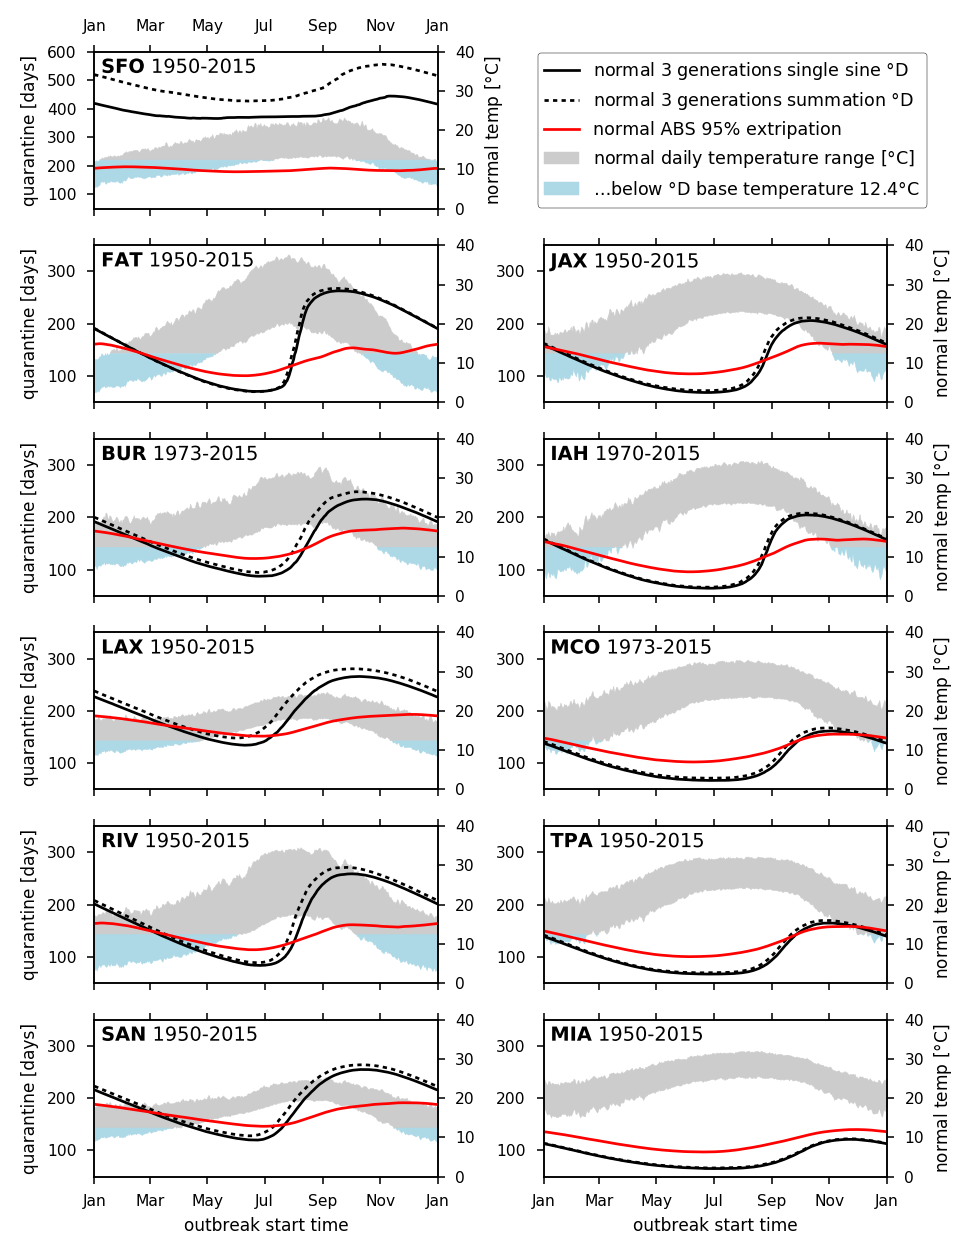

KSFO 1950-01-01 2016-01-01
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
KFAT 1950-01-01 2016-01-01
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
KBUR 1973-01-01 2016-01-01
Computing using range: 1973-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
Computing using range: 1973-01-01 00:00:00-08:00 to 2016-01-0

In [13]:
fig = plt.figure(figsize=[7,9])
plotrows = 6
plotcols = 2
gs = mpl.gridspec.GridSpec(plotrows, plotcols)
lrefax = None
lrefax = None

for runseti, (RUNSET, LOCAL_TIME_OFFSET, START_DATE, END_DATE) in enumerate(RUNSETS):
    ploti = RUNSET_IDX_2_PLOT_IDX[runseti]

    sitetz = dat[RUNSET]['sitetz']
    tempdf = dat[RUNSET]['tempdf']
    sumdd = dat[RUNSET]['sumdd']
    # tridd = dat[RUNSET]['tridd'] # not used for this plot
    bmdd = dat[RUNSET]['bmdd']
    # ppdf = dat[RUNSET]['ppdf'] # not used for this plot
    pe95 = dat[RUNSET]['pe95']

    print(RUNSET, START_DATE, END_DATE) # just informative/progress output

    # normal of degree-day crossings
    sumdd_norm, sumdd_resamp = compute_year_over_year_norm(sumdd['dur_days'],
                                         START_DATE, END_DATE,
                                         norm_start=START_DATE,
                                         norm_end=END_DATE,
                                         freq='daily',
                                         interp_method=None)
    bmdd_norm, bmdd_resamp = compute_year_over_year_norm(bmdd['dur_days'],
                                         START_DATE, END_DATE,
                                         norm_start=START_DATE,
                                         norm_end=END_DATE,
                                         freq='daily',
                                         interp_method=None)

    # normal of MedFoes 95% extirpation
    pe95_norm, pe95_resamp = compute_year_over_year_norm(pe95,
                                       START_DATE, END_DATE,
                                       norm_start=START_DATE,
                                       norm_end=END_DATE,
                                       freq='daily',
                                       interp_method='linear')


    ax2 = fig.add_subplot(gs[int(ploti/plotcols), int(ploti%plotcols)])
    ax = ax2.twinx()
    # put ax in front of ax2 
    ax2.set_zorder(ax.get_zorder()+1)
    ax.patch.set_visible(True)
    ax2.patch.set_visible(False)

    # use an arbitarary single year range of the normals (it is just repeated)
    r1 = '2011-01-01'
    r2 = '2012-01-01'

    ## Temperature
    # compute normals of the daily min and max tempeatures
    maxtempnorm, maxtempresamp = compute_year_over_year_norm(tempdf['AT'].groupby(pd.TimeGrouper('D')).max(),
                                                       START_DATE, END_DATE,
                                                       norm_start=START_DATE,
                                                       norm_end=END_DATE,
                                                       freq='daily',
                                                       interp_method=None)
    mintempnorm, mintempresamp = compute_year_over_year_norm(tempdf['AT'].groupby(pd.TimeGrouper('D')).min(),
                                                       START_DATE, END_DATE,
                                                       norm_start=START_DATE,
                                                       norm_end=END_DATE,
                                                       freq='daily',
                                                       interp_method=None)
    minx = mintempnorm.loc[r1:r2]
    maxx = maxtempnorm.loc[r1:r2]
    # above DD_BASE_TEMP
    nx = minx.copy(deep=True)
    nx[nx<DD_BASE_TEMP] = DD_BASE_TEMP
    xx = maxx.copy(deep=True)
    xx[xx<DD_BASE_TEMP] = np.nan
    if len(xx.dropna()) > 0:
        ax.fill_between(nx.index, nx.values, xx.values,
                       label=r'normal daily temperature range [$\degree$C]',
                       color='#CCCCCC')
    # below DD_BASE_TEMP
    nx = minx.copy(deep=True)
    nx[nx>DD_BASE_TEMP] = np.nan
    xx = maxx.copy(deep=True)
    xx[xx>DD_BASE_TEMP] = DD_BASE_TEMP
    if len(nx.dropna()) > 0:
        ax.fill_between(xx.index, nx.values, xx.values,
                       label=r'$\ldots$below $\degree$D base temperature {:.1f}$\degree$C'.format(DD_BASE_TEMP),
                       color='lightblue')        
        
    ## main data, quarantine length projections
    y2 = bmdd_norm.loc[r1:r2]
    ax2.plot(y2.index, y2, label=r'normal 3 generations single sine $\degree$D', color='k')
    y2 = sumdd_norm.loc[r1:r2]
    ax2.plot(y2.index, y2, label=r'normal 3 generations summation $\degree$D', color='k', ls=':')
    
    y = pe95_norm.loc[r1:r2]/24.0
    ax2.plot(y.index, y, label=r'normal ABS 95% extripation', color='r')

#     ## points for historic outbreak data
#     t = outbreak_dat[(outbreak_dat['near station']==RUNSET) & (outbreak_dat['Start Date']>'1994') & (outbreak_dat['far'].isnull())]
#     ax2.plot(t['DOY'], t['dur'], color='k', marker='o', ls='none', clip_on=False, label='historic oubreak post-1993')

    
    plt.autoscale(enable=True, tight=True)
    
    ax2.tick_params(axis='x', top=True, bottom=True)
    if ploti == 0:
        ax2.tick_params(axis='x', labeltop=True, labelbottom=False)
    
    if ploti%plotcols == 1 or ploti <= 1:
        ax.set_ylabel('normal temp [$\degree$C]')
    if ploti%plotcols == 0 or ploti <= 1:
        ax2.set_ylabel('quarantine [days]')
    ax2.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
    if ploti > 9:
         ax2.set_xlabel('outbreak start time')
    if ploti > 1 and ploti < 10:
        ax.set_xticklabels([])

    # Title / plot label
#     ax.set_title(RUNSET[-4:]+' {} to {}'.format(
#         pd.to_datetime(START_DATE).strftime('%Y-%m'),
#         pd.to_datetime(END_DATE).strftime('%Y-%m')
#     ))
    tmp = r'$\bf '+RUNSET[-3:]+r'$'+' {}-{}'.format(
                        pd.to_datetime(START_DATE).strftime('%Y'),
                        int(pd.to_datetime(END_DATE).strftime('%Y'))-1)
    txt = ax.text(.02, .96, tmp, transform=ax.transAxes,
                  ha='left', va='top')#, fontsize='large')
    txt.set_path_effects([patheffects.Stroke(linewidth=1.5, foreground='white'),
                          patheffects.Normal()])

    # HARDCODED LIMITS (so all plots are comparable)
    ax.set_ylim([0,40])
    ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
    if RUNSET == 'KSFO': # KSFO needs its own scale
        ax2.set_ylim([50,600])        
    else:
        ax2.set_ylim([50,350])
    
    # some plots (MIA) don't have any values below DD base temp
    # so need to save handles to other axes for legend
    if lrefax is None:
        lrefax = ax
        lrefax2 = ax2
        
# legend

legax = fig.add_subplot(gs[0,1])
h1, l1 = lrefax.get_legend_handles_labels()
h2, l2 = lrefax2.get_legend_handles_labels()
leg = legax.legend(h2+h1, l2+l1, loc='center', fontsize=9,
                   bbox_to_anchor=(.55, .5))
legax.set_frame_on(False)
leg.get_frame().set_facecolor('white')
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_alpha(1)
legax.get_yaxis().set_visible(False)
legax.get_xaxis().set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, 'fig_main.pdf'))

# Super norms
Extends the concept of normal (as in normal temperature) 
to include distributional (quantiles, max, min, ect.) info
instead of just the mean for each set of values grouped by day-of-year. 

In [14]:
def compute_super_norm(in_df, 
                       start_date=None, end_date=None,
                       date_pad='1 days',
                       freq='24h',
                       quantiles=[0.05, 0.25, 0.5, 0.75, 0.95],
                      ):
    if start_date is None:
        start_date = in_df.index[0]
    else:
        start_date = pd.to_datetime(start_date).tz_localize(in_df.index.tz)
    if end_date is None:
        end_date = in_df.index[-1]
    else:
        end_date = pd.to_datetime(end_date).tz_localize(in_df.index.tz)
    date_pad = pd.Timedelta(date_pad)
    
    t = in_df.loc[start_date-date_pad:end_date+date_pad].copy(deep=True)
    
    nidx = pd.date_range(start_date, end_date, freq=freq)

    t = pd.Series(scipy.interpolate.interp1d(
                                            t.index.astype('int64').values, 
                                            t.values, 
                                            kind='linear',
                                            fill_value=np.nan, #(0,1) 
                                            bounds_error=False)(nidx.astype('int64').values),
                              index=nidx)

#     gb = t.groupby([t.index.month, t.index.day, t.index.hour])
    gb = t.groupby([t.index.month, t.index.day])

    # start with quantiles
    norm = gb.quantile(quantiles).sort_index()
    # unstack to make each quantile value a column
    norm = norm.to_frame().unstack()
    norm.columns.set_levels(['quantile'], level=0, inplace=True)

    # add the mean and others
    norm['mean'] = gb.mean().sort_index()
    norm['max'] = gb.max().sort_index()
    norm['min'] = gb.min().sort_index()
    norm['std'] = gb.agg(np.std, ddof=0).sort_index()
    norm['skew'] = gb.skew().sort_index()

    norm = norm.drop((2,29,)) # drop leapyear extra day
    
    # Convert the multi-index (month, day, hour) to a datetime index
    # NOTE: year (yr) is abitrary and meaningless beyond being a leapyear or not a leapyear (not is simpler)
    yr = 2011
#     idx = pd.date_range(start='{}-{:02d}-{:02d} {:02d}:00:00'.format(yr,*norm.index[0]),
#                         end=  '{}-{:02d}-{:02d} {:02d}:00:00'.format(yr,*norm.index[-1]),
#                         freq='24h',
#                         tz=t.index.tz)
    idx = pd.date_range(start='{}-{:02d}-{:02d} 00:00:00'.format(yr,*norm.index[0]),
                    end=  '{}-{:02d}-{:02d} 00:00:00'.format(yr,*norm.index[-1]),
                    freq='24h',
                    tz=t.index.tz)
    norm.index = idx
    
    return norm

# Uncertainty in quarantine length
The idea is to simply show how much predicted quarantine length varies
to give an indication of uncertainty in quarantine length for management decisions

<IPython.core.display.Javascript object>


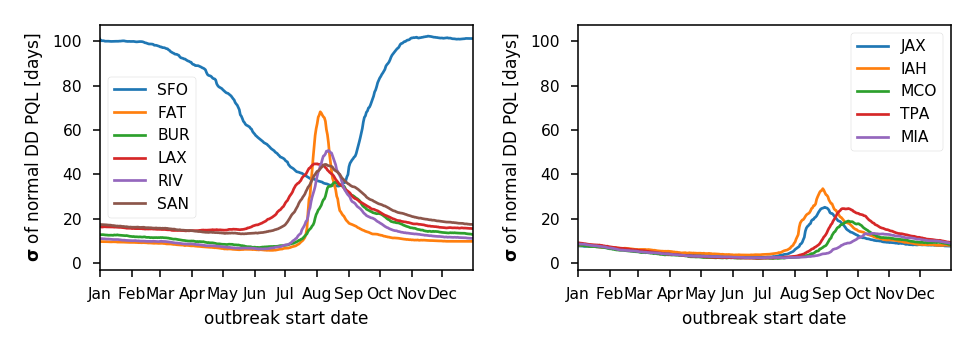

KSFO	77.85879142686653	88.72586002352752	102.281136579
KFAT	12.878791033876473	9.565983216292956	68.1746343017
KBUR	14.767131389181838	12.54573030306364	36.4834434248
KLAX	21.148309192844845	16.347333348949338	44.7627559014
KRIV	14.517064991267887	10.812408271770234	50.7758718721
KSAN	21.089009439520233	17.421323866242922	44.4586894642
KJAX	7.916020380924844	6.684961124356654	25.1602394508
KIAH	9.385535779560515	7.121581194829964	33.5412169206
KMCO	6.759785234454232	5.408664402785388	18.9722977007
KTPA	8.390774214680341	6.498869718779664	24.5996035714
KMIA	6.2562050340726	4.93076491103532	13.4507997106


In [15]:
fig = plt.figure(figsize=[7,2.5])
plotrows = 1
plotcols = 2
gs = mpl.gridspec.GridSpec(plotrows, plotcols)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1], sharey=ax1)
    
for ploti, (RUNSET, LOCAL_TIME_OFFSET, START_DATE, END_DATE) in enumerate(RUNSETS):
    norm = compute_super_norm(dat[RUNSET]['bmdd']['dur_days'], START_DATE, END_DATE)
        
    if ploti < 6:
        ax = ax1
    else:
        ax = ax2
        
    ax.plot(norm.index, norm['std'], label=RUNSET[-3:])
    ax.set_ylabel(r'$\bf\sigma$ of normal DD PQL [days]')
    
    print(RUNSET, norm['std'].mean(), norm['std'].median(), norm['std'].max(), sep='\t')
    
for ax in [ax1,ax2]:
    ax.autoscale(enable=True, axis='x', tight=True)
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
    ax.set_xlabel('outbreak start date')
    ax.legend()

# fig.suptitle('Standard Deviation of normal 3 generation single sine degree day (DD PQL)')
# gs.tight_layout(fig, rect=[0, 0, 1, 0.97])
fig.tight_layout()

plt.savefig(os.path.join(FIGDIR, 'fig_BMDD_variation.pdf'))

<IPython.core.display.Javascript object>


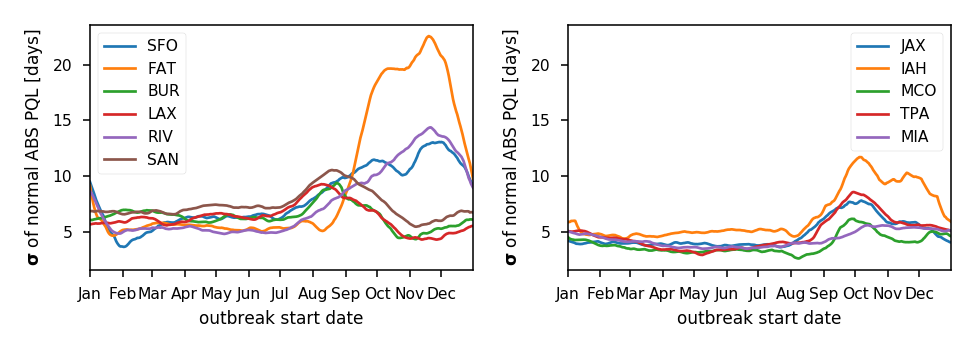

KSFO	8.089285271084453	6.996541005368922	13.0690067868
KFAT	9.567848717100324	5.700426187913643	22.5554251065
KBUR	6.4121330544571755	6.306553693127763	9.39731119563
KLAX	6.345395959499196	6.248667996198588	9.29310715285
KRIV	7.664627505631115	5.843875611759095	14.3778566917
KSAN	7.418594735002889	7.143002580442788	10.5587218985
KJAX	4.782997016528525	4.055497960630475	7.82322029877
KIAH	6.471983205743969	5.178417218213431	11.7170695346
KMCO	3.9005237237392776	3.498214790921634	6.18694806443
KTPA	4.8304770680640505	4.391061002142622	8.58181117328
KMIA	4.369808798270775	4.155331367705725	5.61382906761


In [16]:
fig = plt.figure(figsize=[7,2.5])
plotrows = 1
plotcols = 2
gs = mpl.gridspec.GridSpec(plotrows, plotcols)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1], sharey=ax1)
    
for ploti, (RUNSET, LOCAL_TIME_OFFSET, START_DATE, END_DATE) in enumerate(RUNSETS):
    norm = compute_super_norm(dat[RUNSET]['pe95']/24, START_DATE, END_DATE)
        
    if ploti < 6:
        ax = ax1
    else:
        ax = ax2
        
    ax.plot(norm.index, norm['std'], label=RUNSET[-3:])
    ax.set_ylabel(r'$\bf\sigma$ of normal ABS PQL [days]')

    print(RUNSET, norm['std'].mean(), norm['std'].median(), norm['std'].max(), sep='\t')
    
for ax in [ax1,ax2]:
    ax.autoscale(enable=True, axis='x', tight=True)
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
    ax.set_xlabel('outbreak start date')
    ax.legend()

# fig.suptitle('Standard Deviation of normal MED-FOES 95% extirpation (pe95)')
# gs.tight_layout(fig, rect=[0, 0, 1, 0.97])
fig.tight_layout()

plt.savefig(os.path.join(FIGDIR, 'fig_pe95_variation.pdf'))

## More complete super-norm distribution figures for supplemental

In [17]:
def plot_all_supernorm(datakey,
                       datafunc=None,
                       datafreq='24h',
                       ylim=None,
                       ylim_dict={},
                       xlabel='INDEX',
                       ylabel='VALUE',
                       legend_title=None,
                       subplot_label_pos=(0.02, 0.96),
                       subplot_label_pos_dict={},
                       historic_pts=None,
                      ):

    fig = plt.figure(figsize=[7,9])
    plotrows = 6
    plotcols = 2
    gs = mpl.gridspec.GridSpec(plotrows, plotcols)

    for runseti, (RUNSET, LOCAL_TIME_OFFSET, START_DATE, END_DATE) in enumerate(RUNSETS):
        ploti = RUNSET_IDX_2_PLOT_IDX[runseti]
        print(RUNSET, START_DATE, END_DATE)

        ########################
        if datafunc is not None:
            norm = compute_super_norm(datafunc(dat[RUNSET][datakey]), START_DATE, END_DATE, freq=datafreq)
        else:
            norm = compute_super_norm(dat[RUNSET][datakey], START_DATE, END_DATE, freq=datafreq)

        ## plot
        ax = fig.add_subplot(gs[int(ploti/plotcols), int(ploti%plotcols)])

        ax.fill_between(norm.index, norm[('quantile',0.25)].values, norm[('quantile',0.75)].values,
                       label='0.25 to 0.75 quantile range',
                       color='#AAAAAA')

        ax.plot(norm.index, norm[('quantile',0.5)], 'k-', lw=.75, label='median')
        ax.plot(norm.index, norm['mean'], 'r-', lw=.75, label='mean')

        ax.plot(norm.index, norm['min'], ls=':', color='k', lw=.75, label='')
        ax.plot(norm.index, norm['max'], ls=':', color='k', lw=.75, label='minimum & maximum')

    #     ax.plot(norm.index, norm[('quantile',0.05)], ls='-', color='gray', lw=.75, label='')
    #     ax.plot(norm.index, norm[('quantile',0.95)], ls='-', color='gray', lw=.75, label='0.05 & 0.95 quantiles')
    
        ## points for historic outbreak data
        if historic_pts is not None:
            t = historic_pts[historic_pts['near station']==RUNSET]
            ax.plot(t['DOY'], t['dur'], color='k', marker='o', ls='none', label='historic oubreak (1994 or later)')

        ax.autoscale(enable=True, tight=True)
        # potentially hardcoded limits for y (so all plots are comparable)
        if ylim is not None:
            ax.set_ylim(ylim)
        # individually set ylims (from ylim_dict) get highlighted to indicated they aren't the same as the rest
        if ploti in ylim_dict:
            ax.set_ylim(ylim_dict[ploti])
#             for tmp in ax.get_yticklabels():
#                 tmp.set_fontweight('bold')
            ax.yaxis.set_tick_params(labelcolor='firebrick')

        # ticks and labels (only on certain plots)
        ax.tick_params(axis='x', top=True, bottom=True)
        if ploti == 0:
            ax.tick_params(axis='x', labeltop=True, labelbottom=False) 
        if ploti%plotcols == 0 or ploti <= 1:
            ax.set_ylabel(ylabel)
        ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
        if ploti > 9:
             ax.set_xlabel(xlabel)
        if ploti > 1 and ploti < 10:
            ax.set_xticklabels([])

        # labels for each subplot
        tmp = r'$\bf '+RUNSET[-3:]+r'$'+' {}-{}'.format(
                            pd.to_datetime(START_DATE).strftime('%Y'),
                            int(pd.to_datetime(END_DATE).strftime('%Y'))-1)
        tx,ty = subplot_label_pos
        if ploti in subplot_label_pos_dict:
            tx,ty = subplot_label_pos_dict[ploti]
        txt = ax.text(tx, ty, tmp, transform=ax.transAxes,
                      ha='left', va='top')#, fontsize='large')
        txt.set_path_effects([patheffects.Stroke(linewidth=1.5, foreground='white'),
                              patheffects.Normal()])

    # legend
    legax = fig.add_subplot(gs[0,1])
    h1, l1 = ax.get_legend_handles_labels()
    leg = legax.legend(h1, l1, loc='center', 
                       fontsize=9,
                       bbox_to_anchor=(.5, .5),
                       title=legend_title)
    leg.get_title().set_fontweight('bold')
    leg.get_title().set_fontsize('large')
    legax.set_frame_on(False)
    leg.get_frame().set_facecolor('white')
    leg.get_frame().set_edgecolor('k')
    leg.get_frame().set_alpha(1)
    legax.get_yaxis().set_visible(False)
    legax.get_xaxis().set_visible(False)

    plt.tight_layout()
    return fig   

<IPython.core.display.Javascript object>


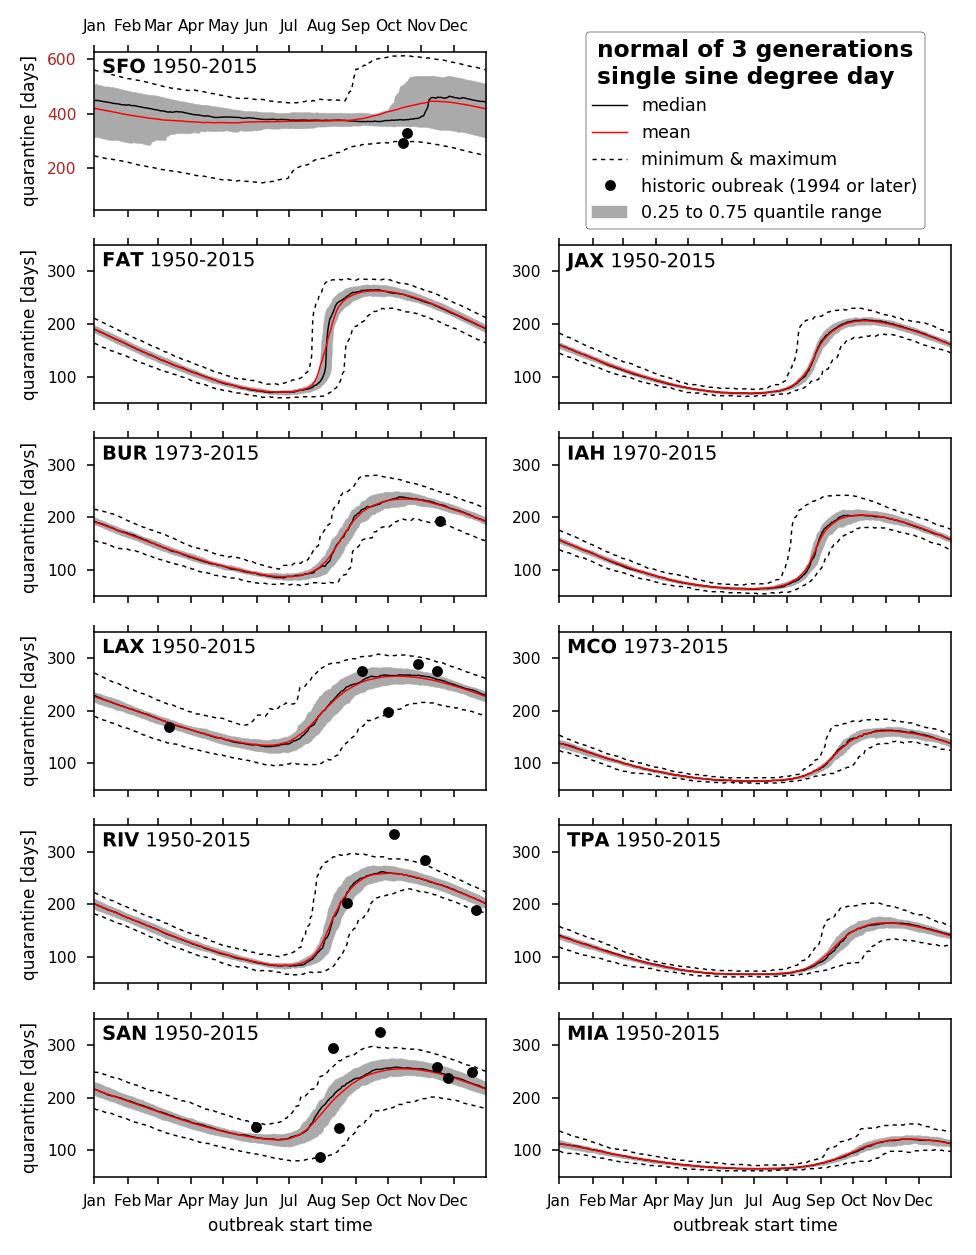

KSFO 1950-01-01 2016-01-01
KFAT 1950-01-01 2016-01-01
KBUR 1973-01-01 2016-01-01
KLAX 1950-01-01 2016-01-01
KRIV 1950-01-01 2016-01-01
KSAN 1950-01-01 2016-01-01
KJAX 1950-01-01 2016-01-01
KIAH 1970-01-01 2016-01-01
KMCO 1973-01-01 2016-01-01
KTPA 1950-01-01 2016-01-01
KMIA 1950-01-01 2016-01-01


In [18]:
fig = plot_all_supernorm('bmdd',
                         datafunc=lambda x: x['dur_days'],
                         ylim=[50,350],
                         ylim_dict={0:(50,625)},
                         xlabel='outbreak start time',
                         ylabel='quarantine [days]',
                         legend_title='normal of 3 generations\nsingle sine degree day',
                         historic_pts=outbreak_dat[(outbreak_dat['Start Date']>'1994') & 
                                                   (outbreak_dat['far'].isnull())],
                        )
fig.savefig(os.path.join(FIGDIR, 'fig_all_BMDD_supernorm.pdf'))

<IPython.core.display.Javascript object>


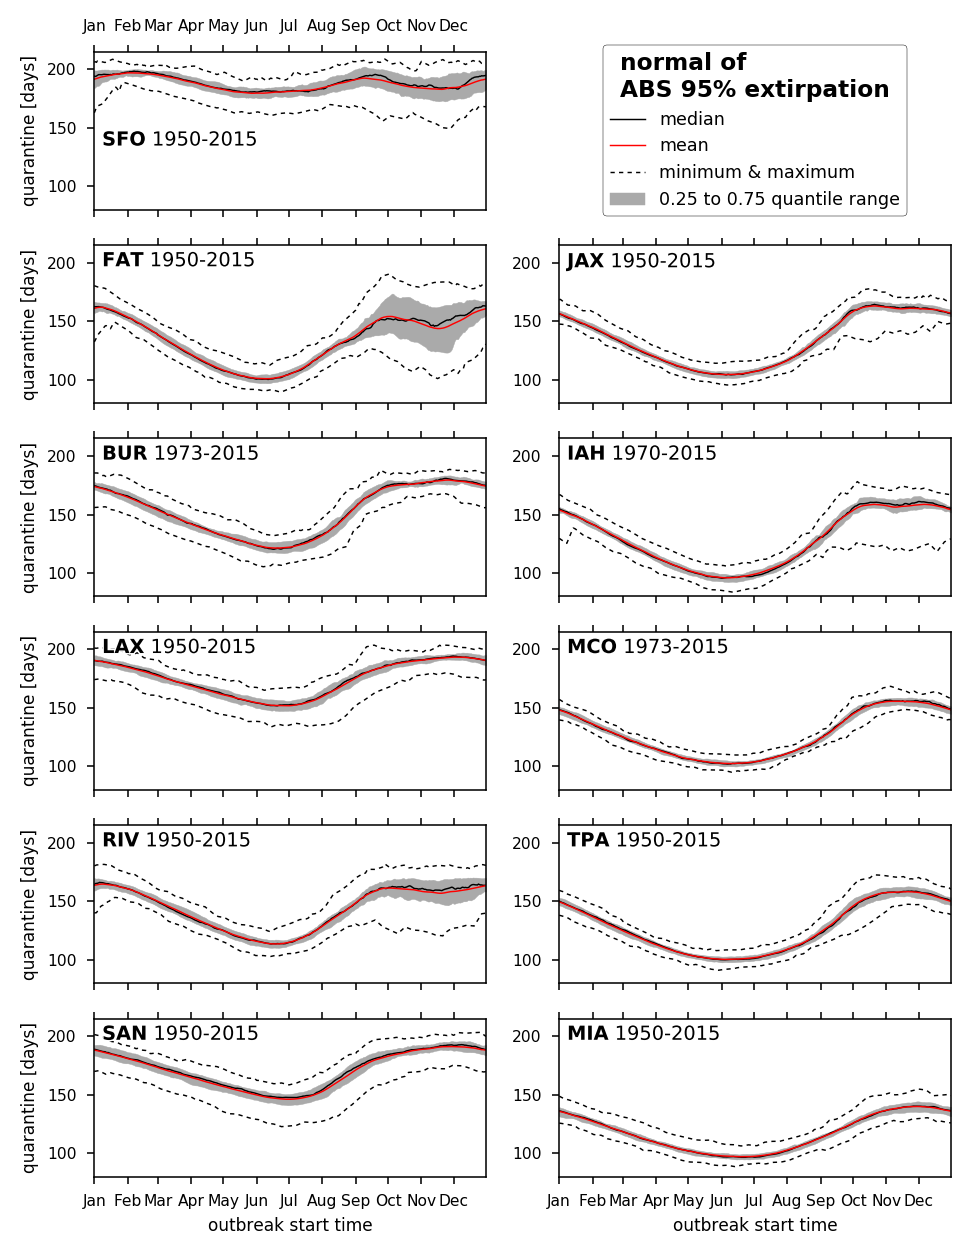

KSFO 1950-01-01 2016-01-01
KFAT 1950-01-01 2016-01-01
KBUR 1973-01-01 2016-01-01
KLAX 1950-01-01 2016-01-01
KRIV 1950-01-01 2016-01-01
KSAN 1950-01-01 2016-01-01
KJAX 1950-01-01 2016-01-01
KIAH 1970-01-01 2016-01-01
KMCO 1973-01-01 2016-01-01
KTPA 1950-01-01 2016-01-01
KMIA 1950-01-01 2016-01-01


In [19]:
fig = plot_all_supernorm('pe95',
                         datafunc=lambda x: x/24.0,
                         ylim=[80,215],
                         xlabel='outbreak start time',
                         ylabel='quarantine [days]',
                         legend_title='normal of\nABS 95% extirpation',
                         subplot_label_pos_dict={0:(0.02, 0.5)},
                        )
fig.savefig(os.path.join(FIGDIR, 'fig_all_pe95_supernorm.pdf'))

<IPython.core.display.Javascript object>


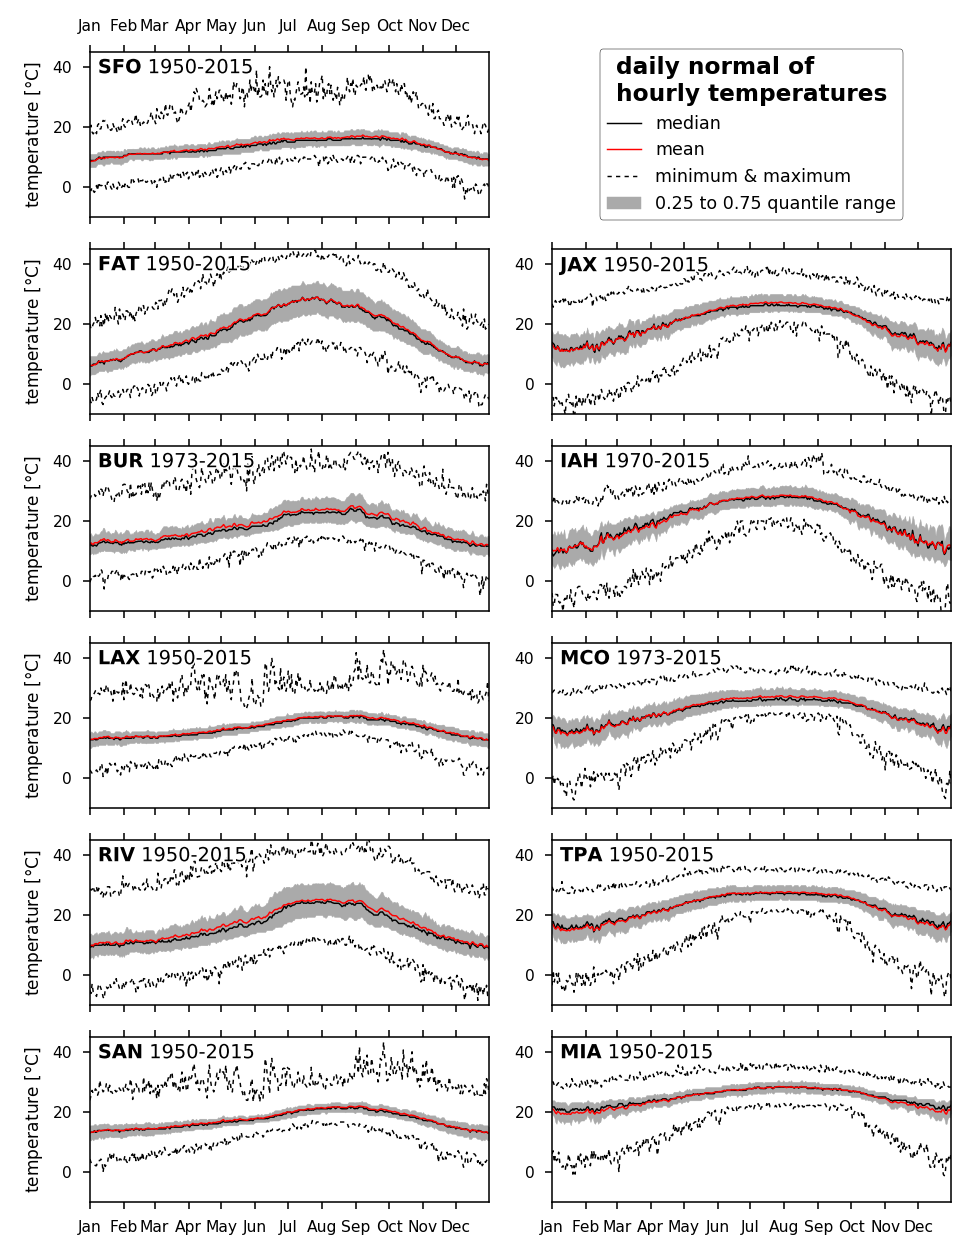

KSFO 1950-01-01 2016-01-01
KFAT 1950-01-01 2016-01-01
KBUR 1973-01-01 2016-01-01
KLAX 1950-01-01 2016-01-01
KRIV 1950-01-01 2016-01-01
KSAN 1950-01-01 2016-01-01
KJAX 1950-01-01 2016-01-01
KIAH 1970-01-01 2016-01-01
KMCO 1973-01-01 2016-01-01
KTPA 1950-01-01 2016-01-01
KMIA 1950-01-01 2016-01-01


In [20]:
fig = plot_all_supernorm('tempdf',
                         datafunc=lambda x: x['AT'],
                         datafreq='1h',
                         ylim=[-10,45],
                         xlabel='',
                         ylabel='temperature [$\degree$C]',
                         legend_title='daily normal of\nhourly temperatures',
                        )
fig.savefig(os.path.join(FIGDIR, 'fig_all_hourly_temps_supernorm.pdf'))

# Amount of variance captured by normal ($R^2$)

In [21]:
vardf = pd.DataFrame(columns=['BMDD_R2', 'BMDD_adjR2', 'BMDD_N', 'BMDD_P',
                              'pe95_R2', 'pe95_adjR2', 'pe95_N', 'pe95_P'])

for ploti, (RUNSET, LOCAL_TIME_OFFSET, START_DATE, END_DATE) in enumerate(RUNSETS):
    sitetz = dat[RUNSET]['sitetz']
    tempdf = dat[RUNSET]['tempdf']
    sumdd = dat[RUNSET]['sumdd']['dur_days']
    bmdd = dat[RUNSET]['bmdd']['dur_days']
    pe95 = dat[RUNSET]['pe95']

#     print(RUNSET, START_DATE, END_DATE) # just informative/progress output

    # normal of degree-day crossings
    bmdd_norm, bmdd_resamp = compute_year_over_year_norm(bmdd,
                                         START_DATE, END_DATE,
                                         norm_start=START_DATE,
                                         norm_end=END_DATE,
                                         freq='daily',
                                         interp_method=None,
                                         quiet=True)

    # normal of MedFoes 95% extirpation
    pe95_norm, pe95_resamp = compute_year_over_year_norm(pe95/24.0, # converting from hours to days
                                       START_DATE, END_DATE,
                                       norm_start=START_DATE,
                                       norm_end=END_DATE,
                                       freq='daily',
                                       interp_method='linear',
                                       quiet=True)
    
    idx = bmdd.loc[START_DATE:END_DATE].index
    bmdd_r2 = 1-(bmdd.loc[idx]-bmdd_norm.loc[idx]).var()/bmdd.loc[idx].var()
    bmdd_n = bmdd.loc[idx].count()
    bmdd_p = bmdd_norm.loc['2001-01-01 00:00:00':'2001-12-31 23:59:59'].count()
    bmdd_adjr2 = bmdd_r2-(1-bmdd_r2)*bmdd_p/(bmdd_n-bmdd_p-1)

    # have to round pe95 index to nearest day (midnight) since
    # temperature infile was in localtime instead of fixed-offset and
    # daylight-savings-time causes "off by one hour" problems
    rpe95 = pe95.copy(deep=True)/24.0 # convert from hours to days
    rpe95.index = pe95.index.round('D')

    idx = rpe95.loc[START_DATE:END_DATE].index
    pe95_r2 = 1-(rpe95.loc[idx]-pe95_norm.loc[idx]).var()/rpe95.loc[idx].var()
    pe95_n = rpe95.loc[idx].count()
    pe95_p = pe95.loc['2001-01-01 00:00:00':'2001-12-31 23:59:59'].count()
    pe95_adjr2 = pe95_r2-(1-pe95_r2)*pe95_p/(pe95_n-pe95_p-1)
    
#     print("{}\t{:5.2f}%\t{:5.2f}%".format(RUNSET, 
#             bmdd_var_captured*100, pe95_var_captured*100))
    
    vardf.loc[RUNSET] = {'BMDD_R2': bmdd_r2,
                         'BMDD_adjR2': bmdd_adjr2,
                         'BMDD_N': bmdd_n,
                         'BMDD_P': bmdd_p,
                         'pe95_R2': pe95_r2,
                         'pe95_adjR2': pe95_adjr2,
                         'pe95_N': pe95_n,
                         'pe95_P': pe95_p,
                        }
        
display(vardf)

,BMDD_R2,BMDD_adjR2,BMDD_N,BMDD_P,pe95_R2,pe95_adjR2,pe95_N,pe95_P
KSFO,0.091187,0.077215,24107.0,365.0,0.280143,0.269104,3444.0,52.0
KFAT,0.939310,0.938377,24107.0,365.0,0.756817,0.753088,3444.0,52.0
KBUR,0.907088,0.904877,15706.0,365.0,0.908849,0.906685,2243.0,52.0
KLAX,0.801672,0.798623,24107.0,365.0,0.830676,0.828079,3444.0,52.0
KRIV,0.922344,0.921150,24107.0,365.0,0.818854,0.816076,3444.0,52.0
KSAN,0.809900,0.806977,24107.0,365.0,0.809105,0.806178,3444.0,52.0
KJAX,0.964525,0.963979,24107.0,365.0,0.947845,0.947045,3444.0,52.0
KIAH,0.950957,0.949868,16802.0,365.0,0.918054,0.916238,2400.0,52.0
KMCO,0.946190,0.944910,15706.0,365.0,0.957681,0.956677,2244.0,52.0
KTPA,0.919124,0.917880,24107.0,365.0,0.944016,0.943158,3444.0,52.0


In [22]:
vardf.median()

BMDD_R2           0.919124
BMDD_adjR2        0.917880
BMDD_N        24107.000000
BMDD_P          365.000000
pe95_R2           0.908849
pe95_adjR2        0.906685
pe95_N         3444.000000
pe95_P           52.000000
dtype: float64

# Latitude dependence

<IPython.core.display.Javascript object>


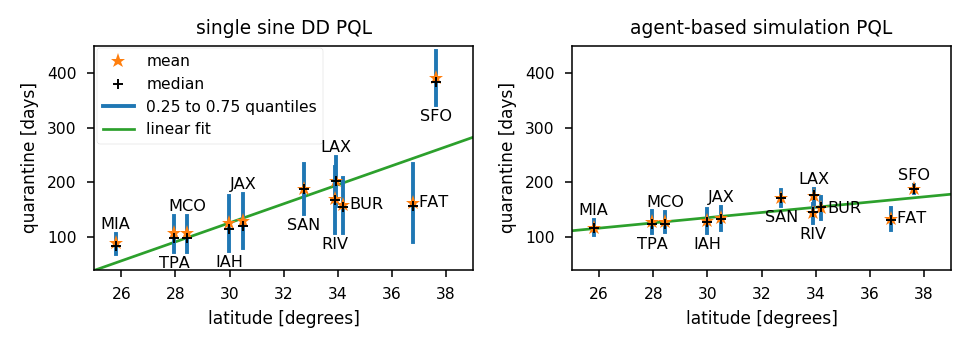

Intercept   -396.596962
lat           17.407497
dtype: float64

/home/travc/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1327: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 median   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     14.10
Date:                Fri, 25 Aug 2017   Prob (F-statistic):            0.00452
Time:                        03:35:44   Log-Likelihood:                -58.600
No. Observations:                  11   AIC:                             121.2
Df Residuals:                       9   BIC:                             122.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   -396.5970    149.223     -2.658      0.026      -734.162   -59.032
lat           17.4075      4.636      3.755      0.005         6.919    27.896
==============================================================================
Omnibus:                        6.577   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                2.468
Skew:                           0.893   Prob(JB):                        0.291
Kurtosis:                       4.481   Cond. No.                         290.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Intercept   -8.130471
lat          4.772040
dtype: float64

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 median   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     10.48
Date:                Fri, 25 Aug 2017   Prob (F-statistic):             0.0102
Time:                        03:35:44   Log-Likelihood:                -45.995
No. Observations:                  11   AIC:                             95.99
Df Residuals:                       9   BIC:                             96.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -8.1305     47.443     -0.171      0.868      -115.454    99.193
lat            4.7720      1.474      3.237      0.010         1.437     8.107
==============================================================================
Omnibus:                        1.746   Durbin-Watson:                   2.625
Prob(Omnibus):                  0.418   Jarque-Bera (JB):                0.351
Skew:                          -0.418   Prob(JB):                        0.839
Kurtosis:                       3.255   Cond. No.                         290.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
SKIP_SFO = False

fig = plt.figure(figsize=(7,2.5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
legh = None

bmdd_stats_df = pd.DataFrame(columns=['N','lat','mean','median', 'q25', 'q75'])
pe95_stats_df = pd.DataFrame(columns=['N','lat','mean','median', 'q25', 'q75'])

for runseti, (RUNSET, LOCAL_TIME_OFFSET, START_DATE, END_DATE) in enumerate(RUNSETS):
    if SKIP_SFO and RUNSET == 'KSFO': continue
    bmdd = dat[RUNSET]['bmdd']['dur_days']
    pe95 = (dat[RUNSET]['pe95']/24.0)
    lat = siteinfo.loc[RUNSET]['LAT']

    for i,(d,ax) in enumerate([[bmdd,ax1], [pe95,ax2]]):
        # min to max
#         ax.plot([lat,lat], [d.min(),d.max()], ls='-', lw=.75, color='k',
#                 label='min to max')
        # quantiles (0.25, 0.75)
        ax.plot([lat,lat], [d.quantile(0.25),d.quantile(0.75)], ls='-', lw=2, color='C0',
                label='0.25 to 0.75 quantiles')
        # mean and median points
        ax.plot(lat, d.median(), marker='+', ls='none', mew=1, mec='k', mfc='none', label='median', zorder=3)
        ax.plot(lat, d.mean(), marker='*', ms=8, ls='none', color='C1', label='mean')
        
        df = bmdd_stats_df
        if i == 1:
            df = pe95_stats_df
            
        df.loc[RUNSET] = {'N': d.count(), 
                          'lat': lat, 
                          'mean': d.mean(),
                          'median': d.median(),
                          'q25': d.quantile(0.25),
                          'q75': d.quantile(0.75),
                         }

        if legh is None:
            legh, legl = ax.get_legend_handles_labels()

# labeling the sites
for runseti, (RUNSET, LOCAL_TIME_OFFSET, START_DATE, END_DATE) in enumerate(RUNSETS):
    if SKIP_SFO and RUNSET == 'KSFO': continue
    for i,(df,ax) in enumerate([[bmdd_stats_df,ax1], [pe95_stats_df,ax2]]):
        lat = df.loc[RUNSET,'lat']
        if RUNSET in ['KTPA',
                      'KIAH',
                      'KSAN',
                      'KRIV',
                      'KSFO',
                     ] and not ( RUNSET == 'KSFO' and ax == ax2 ):
            ty = df.loc[RUNSET,'q25']
            ax.annotate(RUNSET[1:], xy=[lat, ty],
                         xytext=[0,-2],
                         textcoords='offset points',
                         va='top', ha='center',
                         fontsize='small')
        elif RUNSET in ['KBUR',
                        'KFAT']:
            ty = df.loc[RUNSET,'mean']
            ax.annotate(RUNSET[1:], xy=[lat, ty],
                         xytext=[3,0],
                         textcoords='offset points',
                         va='center', ha='left',
                         fontsize='small')
        else:
            ty = df.loc[RUNSET,'q75']
            ax.annotate(RUNSET[1:], xy=[lat, ty],
                         xytext=[0,1],
                         textcoords='offset points',
                         va='bottom', ha='center',
                         fontsize='small',
                         zorder=9)
            
## OLS fit
MODEL_FORMULA = 'median ~ lat'
EXCLUDE_SITES = []
if SKIP_SFO:
    EXCLUDE_SITES = ['KSFO']
for i,(df,ax) in enumerate([[bmdd_stats_df,ax1], [pe95_stats_df,ax2]]):
    r = smformula.ols(formula=MODEL_FORMULA, 
                           data=df[~df.index.isin(EXCLUDE_SITES)]).fit()
    display(r.params)
    display(r.summary())
    
    xrng = np.array([25,39])
    p, = ax.plot(xrng, (xrng*r.params.lat)+r.params.Intercept, 
                color='C2', zorder=1)
    if i == 0:
        legh.insert(0, p)
        legl.insert(0, 'linear fit')

ax1.autoscale(enable=True, axis='x', tight=True)
ax1.set_ylabel('quarantine [days]')
ax1.set_xlabel('latitude [degrees]')
ax1.set_title('single sine DD PQL')

ax2.autoscale(enable=True, axis='x', tight=True)
ax2.set_ylabel('quarantine [days]')
ax2.set_xlabel('latitude [degrees]')
ax2.set_title('agent-based simulation PQL')

if SKIP_SFO:
    ax1.set_ylim([55,265])
    ax2.set_ylim([55,265])
else:
    ax1.set_ylim([40,450])
    ax2.set_ylim([40,450])

ax1.legend(legh[::-1], legl[::-1], frameon=True, borderaxespad=0.15)

fig.tight_layout()

if SKIP_SFO:
    fig.savefig(os.path.join(FIGDIR, 'fig_latitude_trend_excludeSFO.pdf'))
else:
    fig.savefig(os.path.join(FIGDIR, 'fig_latitude_trend_withSFO.pdf'))

In [24]:
bmdd_stats_df

,N,lat,mean,median,q25,q75
KSFO,24275.0,37.620,391.206797,383.0,341.0,441.0
KFAT,24358.0,36.780,162.594548,157.0,90.0,233.0
KBUR,16211.0,34.201,158.671581,155.0,107.0,207.0
KLAX,24547.0,33.938,201.941256,203.0,157.0,246.0
KRIV,24365.0,33.900,169.303796,167.0,107.0,228.0
KSAN,24389.0,32.734,187.838083,187.0,141.0,233.0
KJAX,24446.0,30.495,128.493864,119.0,79.0,178.0
KIAH,17177.0,29.980,125.079117,114.0,74.0,175.0
KMCO,16095.0,28.434,106.234421,97.0,73.0,139.0
KTPA,24513.0,27.962,106.877086,97.0,72.0,139.0


In [25]:
pe95_stats_df

,N,lat,mean,median,q25,q75
KSFO,3496.0,37.620,187.211192,187.791667,180.218750,195.671875
KFAT,3496.0,36.780,132.992451,131.697917,112.666667,152.083333
KBUR,2295.0,34.201,152.365756,153.833333,132.458333,173.291667
KLAX,3496.0,33.938,174.347337,176.062500,160.958333,188.250000
KRIV,3496.0,33.900,143.375244,145.125000,125.802083,160.083333
KSAN,3496.0,32.734,170.274963,171.576389,156.041667,185.333333
KJAX,3496.0,30.495,133.627332,132.868750,112.458333,154.833333
KIAH,2460.0,29.980,128.420863,127.208333,106.187500,151.546875
KMCO,2304.0,28.434,126.989123,124.041667,108.864583,146.052083
KTPA,3496.0,27.962,126.823681,123.614583,106.704861,147.298611


# Difference between degree day and MED-FOES PQL

In [26]:
# add a difference between bmdd and pe95 to the dat for each runset 
# so we can generate the supernorm and some stats

df = pd.DataFrame(columns=['lat', 'mean', '%days>0'])

for runseti, (RUNSET, LOCAL_TIME_OFFSET, START_DATE, END_DATE) in enumerate(RUNSETS):
    sitetz = dat[RUNSET]['sitetz']
    tempdf = dat[RUNSET]['tempdf']
    bmdd = dat[RUNSET]['bmdd']
    pe95 = dat[RUNSET]['pe95']
    # have to round pe95 index to nearest day (midnight) since
    # temperature infile was in localtime instead of fixed-offset and
    # daylight-savings-time causes "off by one hour" problems
    rpe95 = pe95.copy(deep=True)/24.0 # convert from hours to days
    rpe95.index = pe95.index.round('D')
    # should also round pe95 up to whole days to make it fairly comparable to BMDD
    rpe95 = rpe95.apply(np.ceil)
    
    # using just the days we have run MED-FOES simulations for (every 7 days)
    tmp = bmdd['dur_days'].loc[rpe95.index]-rpe95
    tmp = tmp.loc[START_DATE:END_DATE]

    dat[RUNSET]['bmdd-pe95'] = tmp
    
    # also generate some statistics in tabular form
    df.loc[RUNSET] = [np.nan]*len(df.columns) # add a blank row for the key
    df.loc[RUNSET]['lat'] = siteinfo.loc[RUNSET]['LAT']
    df.loc[RUNSET]['mean'] = tmp.mean()
    df.loc[RUNSET]['%days>0'] = (tmp>0).sum()/tmp.shape[0]*100
    
#     # nicely formatted output
#     if runseti == 0:
#         print('Site','mean differene', 'days BMDD > pe95', sep='\t')
#     print("{}\t{:6.2f}\t{:5.2f}%".format(RUNSET[1:], 
#                       df.loc[RUNSET]['mean'], 
#                       df.loc[RUNSET]['%days>0']), 
#           sep='\t')

display(df)

,lat,mean,%days>0
KSFO,37.62,204.295,99.5354
KFAT,36.78,29.6208,53.5134
KBUR,34.201,5.9893,48.551
KLAX,33.938,27.2738,67.8281
KRIV,33.9,25.7334,56.7073
KSAN,32.734,17.3293,58.4495
KJAX,30.495,-5.49448,36.324
KIAH,29.98,-3.69583,35.3333
KMCO,28.434,-21.2955,13.2353
KTPA,27.962,-20.3278,14.0534


<IPython.core.display.Javascript object>


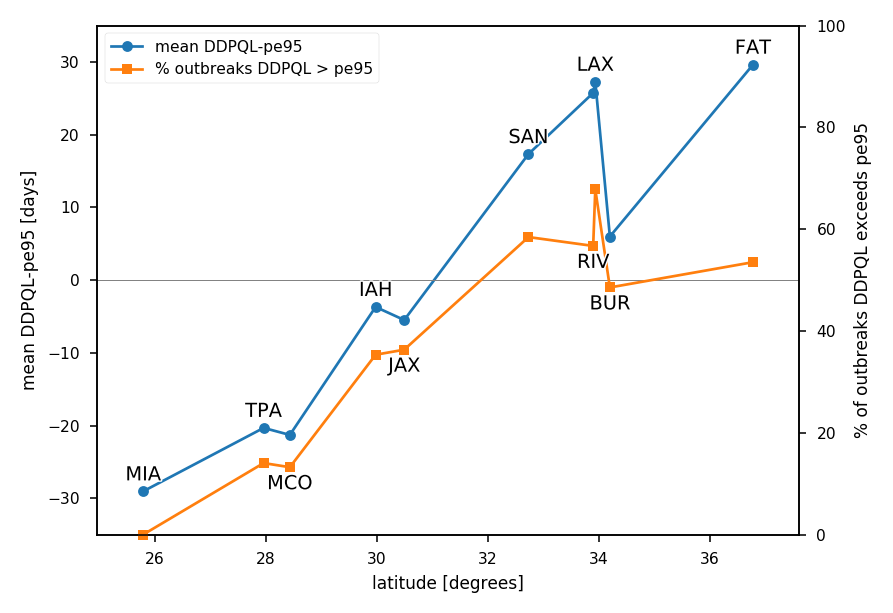

In [27]:
tmp = df.iloc[1:] # omit SFO which is element 0

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax2 = ax.twinx()
ax.margins(0.075,0.075)
ax2.margins(0.075,0.075)

ax.plot(tmp['lat'], tmp['mean'], marker='o', color='C0', 
        label='mean DDPQL-pe95', clip_on=False)
ax2.plot(tmp['lat'], tmp['%days>0'], marker='s', color='C1',
         label='% outbreaks DDPQL > pe95', clip_on=False)

ax.set_ylim([-35,35])
ax2.set_ylim([0,100])

ax.axhline(0, lw=.5, color='gray')

# annotating points with site names... a bit complicated to make nice
trans_offset_up = mpl.transforms.offset_copy(ax.transData, fig=fig, x=0, y=.05)
trans_offset_down = mpl.transforms.offset_copy(ax.transData, fig=fig, x=0, y=-.05)
for i,rs in enumerate(tmp.index):
    ym = ax.transData.transform((0,tmp.loc[rs]['mean']))[1]
    yd = ax2.transData.transform((0,tmp.loc[rs]['%days>0']))[1]
    if i != len(tmp.index)-1 and i%2 == 1:
        if ym < yd:
            a = ax2.text(tmp.loc[rs]['lat'], tmp.loc[rs]['mean'], rs[1:],
                    ha='center', va='top', transform=trans_offset_down)
        else:
            y = ax.transData.inverted().transform((0,yd))[1]
            a = ax2.text(tmp.loc[rs]['lat'], y, rs[1:],
                    ha='center', va='top', transform=trans_offset_down)
    else:
        if ym > yd:
            a = ax2.text(tmp.loc[rs]['lat'], tmp.loc[rs]['mean'], rs[1:],
                    ha='center', va='bottom', transform=trans_offset_up)
        else:
            y = ax.transData.inverted().transform((0,yd))[1]
            a = ax2.text(tmp.loc[rs]['lat'], y, rs[1:],
                    ha='center', va='bottom', transform=trans_offset_up)
    a.set_path_effects([patheffects.Stroke(linewidth=1.5, foreground='white'),
                        patheffects.Normal()])

ax.set_ylabel('mean DDPQL-pe95 [days]')
ax2.set_ylabel('% of outbreaks DDPQL exceeds pe95')
ax.set_xlabel('latitude [degrees]')

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
leg = ax.legend(h1+h2, l1+l2)

fig.tight_layout()

<IPython.core.display.Javascript object>


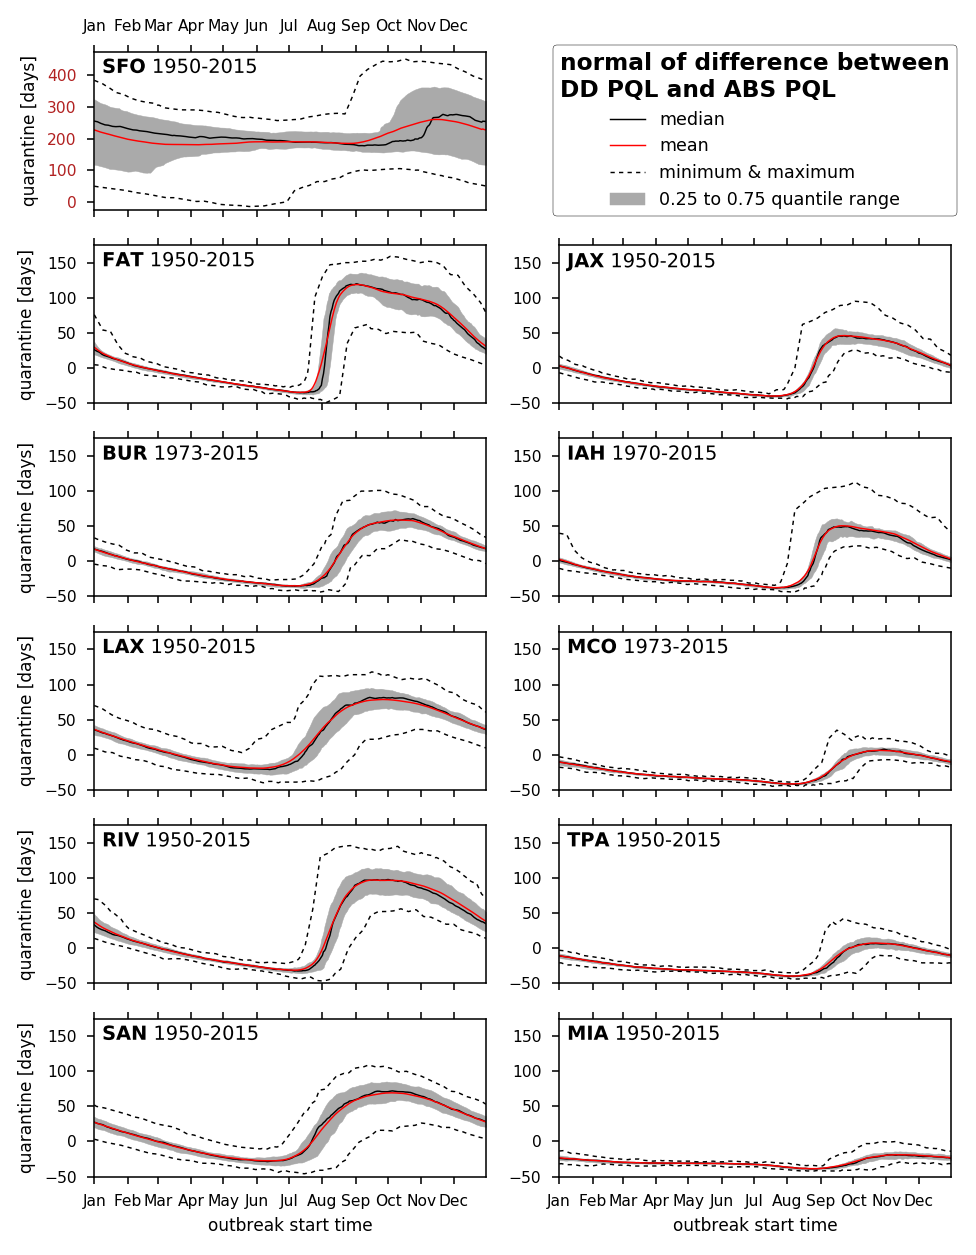

KSFO 1950-01-01 2016-01-01
KFAT 1950-01-01 2016-01-01
KBUR 1973-01-01 2016-01-01
KLAX 1950-01-01 2016-01-01
KRIV 1950-01-01 2016-01-01
KSAN 1950-01-01 2016-01-01
KJAX 1950-01-01 2016-01-01
KIAH 1970-01-01 2016-01-01
KMCO 1973-01-01 2016-01-01
KTPA 1950-01-01 2016-01-01
KMIA 1950-01-01 2016-01-01


In [28]:
fig = plot_all_supernorm('bmdd-pe95',
                         #datafunc=lambda x: x['dur_days'],
                         ylim=[-50,175],
                         ylim_dict={0:(-25,475)},
                         xlabel='outbreak start time',
                         ylabel='quarantine [days]',
                         legend_title='normal of difference between\n'+
                         'DD PQL '+
                         'and ABS PQL',
                        )
fig.savefig(os.path.join(FIGDIR, 'fig_all_BMDD-pe95_supernorm.pdf'))

## Difference between PQLs (for the same dates) between some sites

Plot is median and quantiles (0.25 to 0.75) of the normal of the PQL differences

<IPython.core.display.Javascript object>


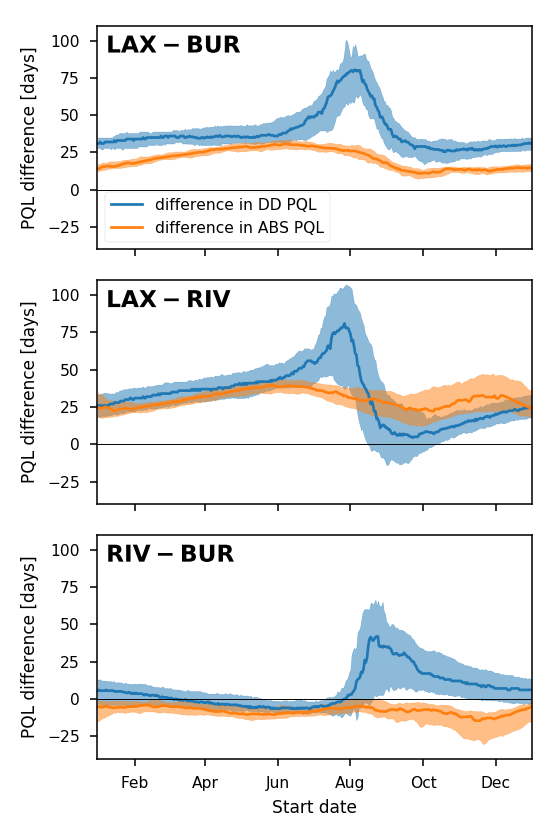

In [29]:
s = [['KLAX','KBUR'],
     ['KLAX','KRIV'],
     ['KRIV','KBUR'],
    ]
fig = plt.figure(figsize=(4,6))

for i, (s1,s2) in enumerate(s):
    ax = fig.add_subplot(3,1,i+1)

    d = (dat[s1]['bmdd']['dur_days']-dat[s2]['bmdd']['dur_days']).dropna()
    norm = compute_super_norm(d)
    ax.fill_between(x=norm.index, y1=norm[('quantile',0.25)], y2=norm[('quantile',0.75)], alpha=0.5, color='C0')
#     ax.plot(norm.index, norm['mean'], label='difference in DD PQL')
    ax.plot(norm.index, norm[('quantile',0.5)], label='difference in DD PQL')

    d = (dat[s1]['pe95']-dat[s2]['pe95']).dropna()/24.0
    norm = compute_super_norm(d)
    ax.fill_between(x=norm.index, y1=norm[('quantile',0.25)], y2=norm[('quantile',0.75)], alpha=0.5, color='C1')
#     ax.plot(norm.index, norm['mean'],  label='difference in MED-FOES PQL')
    ax.plot(norm.index, norm[('quantile',0.5)],  label='difference in ABS PQL')

    ax.axhline(y=0, ls='-', lw=.5, color='k')
    
    txt = ax.text(0.02, 0.96, r'$\bf'+s1[1:]+'-'+s2[1:]+r'$', 
                  transform=ax.transAxes,
                  ha='left', va='top', fontsize='large')
    txt.set_path_effects([patheffects.Stroke(linewidth=1.5, foreground='white'),
                          patheffects.Normal()])
    
    ax.set_xlim(['{}-01-01'.format(dummy_year), '{}-01-01'.format(dummy_year+1)])
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
    ax.set_ylim(-40,110)
    
    ax.set_ylabel('PQL difference [days]')
    if i == 2:
        ax.set_xlabel('Start date')
    else:
        ax.set_xticklabels([])
    
ax = fig.add_subplot(3,1,1)
ax.legend(loc='lower left')
fig.tight_layout()
fig.savefig(os.path.join(FIGDIR, 'fig_between_site_differences_LA.pdf'))

In [30]:
s1 = 'KLAX'
s2 = 'KBUR'
d = (dat[s1]['bmdd']['dur_days']-dat[s2]['bmdd']['dur_days']).dropna()
d.describe()

count    16146.000000
mean        39.197015
std         18.873972
min          4.000000
25%         28.000000
50%         35.000000
75%         45.000000
max        142.000000
Name: dur_days, dtype: float64

In [31]:
s1 = 'KLAX'
s2 = 'KBUR'
d = (dat[s1]['pe95']-dat[s2]['pe95']).dropna()/24.0
d.describe()

count    2295.000000
mean       21.039829
std         7.943720
min         0.915972
25%        14.750000
50%        20.895833
75%        27.322917
max        42.083333
dtype: float64

# Historic outbreaks (APHIS data from CA)

In [32]:
# Load (already done above, but is quick)
FN = os.path.join(DATADIR,"APHIS CA quarantines.csv")
ho = pd.read_csv(FN, parse_dates=['Start Date', 'End Date'])
# cleanup a bit
ho.drop('Fruit Fly Name',1, inplace=True)
# add duration column
ho['dur'] = (ho['End Date']-ho['Start Date']).apply(lambda x:x.days)
# add a day-of-year column
t = ho['Start Date']
ho['DOY'] = t.apply(lambda x: x.replace(year=dummy_year))
ho

,Year,City,County,near station,far,Start Date,End Date,Area (Mi2),Q Code,Male (Mature),Fe Imm (Unmated),Fe Mature (Unmated),Female (Mated),Larvae,dur,DOY
0,1975-1976,Venice,Los Angeles,KLAX,NaN,1975-11-14,1976-08-02,100,Q02MED01,77.0,NaN,NaN,NaN,12.0,262,2011-11-14
1,1980,Northridge,Los Angeles,KBUR,NaN,1980-07-15,1980-12-18,100,Q03MED02,4.0,NaN,NaN,NaN,1.0,156,2011-07-15
2,1980-1982,Santa Clara,Santa Clara,KSFO,NaN,1980-07-15,1982-09-21,3971,Q04MED03,400.0,NaN,NaN,NaN,NaN,798,2011-07-15
3,1987-1988,East LA/Maywood,Los Angeles,KLAX,NaN,1987-08-21,1988-02-05,110,Q12MED04,42.0,NaN,NaN,NaN,1.0,168,2011-08-21
4,1988,Northridge,Los Angeles,KBUR,NaN,1988-07-27,1988-11-15,62,Q15MED05,6.0,NaN,NaN,NaN,NaN,111,2011-07-27
5,1988-1989,West Los Angeles,Los Angeles,KLAX,NaN,1988-10-07,1989-06-12,76,Q16MED06,48.0,NaN,NaN,NaN,1.0,248,2011-10-07
6,1989-1990,Elysia Park,Los Angeles,KBUR,NaN,1989-08-10,1990-11-09,1362,Q18MED07,270.0,NaN,NaN,NaN,27.0,456,2011-08-10
7,1989-1990,Mountain View,Santa Clara,KSFO,NaN,1989-09-11,1990-09-14,60,Q19MED08,25.0,NaN,NaN,NaN,2.0,368,2011-09-11
8,1991-1996,Los Angeles,Los Angeles,KLAX,NaN,1991-10-16,1996-06-15,1576,Q24MED09,566.0,NaN,NaN,NaN,274.0,1704,2011-10-16
9,1992-1993,San Jose,Santa Clara,KSFO,NaN,1992-08-04,1993-10-14,62,Q26MED10,129.0,NaN,NaN,NaN,21.0,436,2011-08-04


In [33]:
# number of outbreaks between given day-of-year (DOY)
((ho['DOY'] >= '2011-08-01') & (ho['DOY'] < '2011-09-01')).value_counts()

False    27
True      7
Name: DOY, dtype: int64

In [34]:
# sorted list of outbreak DOY
ho['DOY'].sort_values()

30   2011-03-12
24   2011-06-01
10   2011-07-04
1    2011-07-15
2    2011-07-15
4    2011-07-27
32   2011-07-30
9    2011-08-04
13   2011-08-06
6    2011-08-10
14   2011-08-11
25   2011-08-17
3    2011-08-21
29   2011-08-24
16   2011-09-07
7    2011-09-11
19   2011-09-17
26   2011-09-24
12   2011-10-01
11   2011-10-06
17   2011-10-07
5    2011-10-07
20   2011-10-15
8    2011-10-16
18   2011-10-19
21   2011-10-29
15   2011-11-05
0    2011-11-14
28   2011-11-16
27   2011-11-16
33   2011-11-19
22   2011-11-26
23   2011-12-18
31   2011-12-22
Name: DOY, dtype: datetime64[ns]

<IPython.core.display.Javascript object>


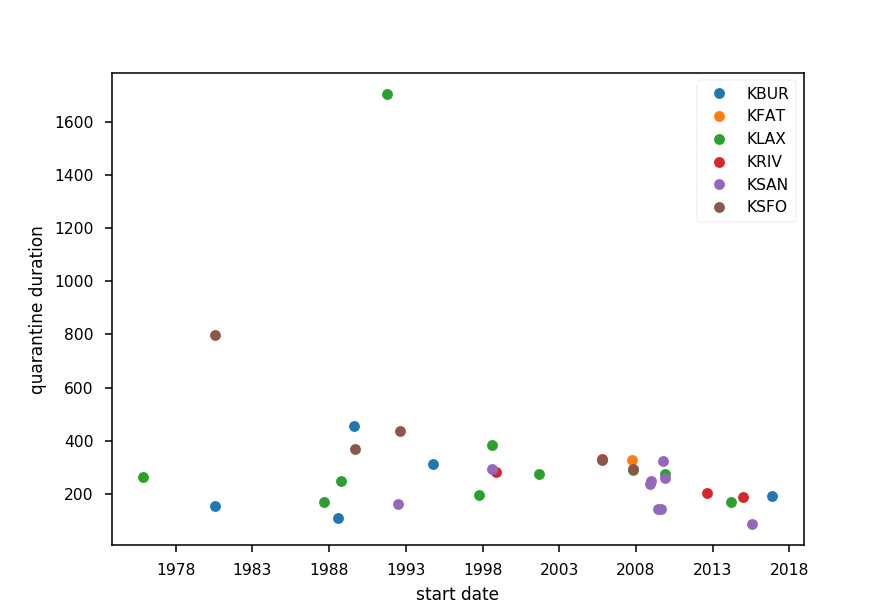

In [35]:
# Quarantines over time
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

gb = ho.groupby('near station')
for k, g in gb:
    ax.plot(g['Start Date'], g['dur'], 'o', label=k)

ax.set_ylabel('quarantine duration')
ax.set_xlabel('start date')
ax.legend()#loc='upper left')

<IPython.core.display.Javascript object>


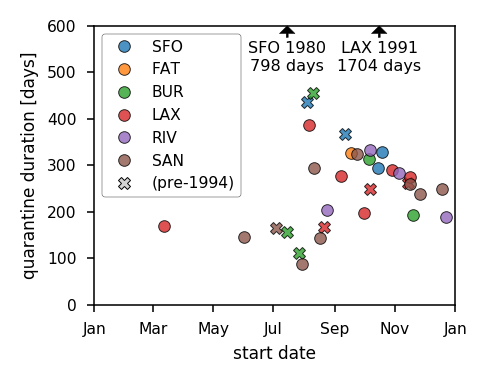

In [36]:
# Quarantines by day-of-year
fig = plt.figure(figsize=(3.5,2.75))
ax = fig.add_subplot(1,1,1)

colors = ['C'+str(int(x)) for x in range(10)]
ci = -1

gb = ho.groupby('near station')
for i, (RUNSET, LOCAL_TIME_OFFSET, START_DATE, END_DATE) in enumerate(RUNSETS):
    if RUNSET in gb.groups:
        ci += 1
        g = gb.get_group(RUNSET)
        t = g[g['Start Date'] < '1994-01-01']
        ax.plot(t['DOY'], t['dur'], ls='none', marker='X', ms=6, mew=0.5, mec='k', color=colors[ci], label='', alpha=0.8)
        t = g[g['Start Date'] >= '1994-01-01']
        ax.plot(t['DOY'], t['dur'], ls='none', marker='o', ms=6, mew=0.5, mec='k', color=colors[ci], label=RUNSET[1:], alpha=0.8)

ax.set_xlim(['{}-01-01'.format(dummy_year), '{}-01-01'.format(dummy_year+1)])
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
ax.set_ylabel('quarantine duration [days]')
ax.set_xlabel('start date')

ax.plot([], [], ls='none', marker='X', ms=6, mfc='lightgray', mec='k', mew=.5, label='(pre-1994)')
ax.legend(loc='upper left', edgecolor='black')

# tighter limit, cutting off some outliers...
ylim = 600
ax.set_ylim(0,ylim)
# annotate those outliers
outlier_annotations = []
t = ho[ho['dur'] > ylim]
for lidx,l in t.iterrows():
    a = ax.annotate("{} {}\n{:d} days".format(l['near station'][1:], l['Start Date'].year, l['dur']),
                    xy=(l['DOY'], ylim), xycoords='data',
                    xytext=(0,-8), textcoords='offset points',
                    ha='center', va='top',
                    fontsize='small',
                    arrowprops=dict(facecolor='k', headwidth=8, headlength=4, width=1))
    outlier_annotations.append(a)
    
fig.tight_layout()#rect=[0,0,1,.93])

fig.savefig(os.path.join(FIGDIR,'fig_historic_quarantines.pdf'), 
            transparent=True, bbox_inches='tight', pad_inches=0,
            bbox_extra_artists=outlier_annotations)

In [37]:
# add normals to the stored values in dat
for runseti, (RUNSET, LOCAL_TIME_OFFSET, START_DATE, END_DATE) in enumerate(RUNSETS):
    sumdd = dat[RUNSET]['sumdd']
    bmdd = dat[RUNSET]['bmdd']
    pe95 = dat[RUNSET]['pe95']

    print(RUNSET, START_DATE, END_DATE) # just informative/progress output

    # normal of degree-day crossings
    sumdd_norm, sumdd_resamp = compute_year_over_year_norm(sumdd['dur_days'],
                                         START_DATE, END_DATE,
                                         norm_start=START_DATE,
                                         norm_end=END_DATE,
                                         freq='daily',
                                         interp_method=None)
    bmdd_norm, bmdd_resamp = compute_year_over_year_norm(bmdd['dur_days'],
                                         START_DATE, END_DATE,
                                         norm_start=START_DATE,
                                         norm_end=END_DATE,
                                         freq='daily',
                                         interp_method=None)

    # normal of MedFoes 95% extirpation
    pe95_norm, pe95_resamp = compute_year_over_year_norm(pe95,
                                       START_DATE, END_DATE,
                                       norm_start=START_DATE,
                                       norm_end=END_DATE,
                                       freq='daily',
                                       interp_method='linear')

    # use an arbitarary single year range of the normals (it is just repeated)
    r1 = '{:d}-01-01'.format(dummy_year)
    r2 = '{:d}-01-01'.format(dummy_year+1)
    
    dat[RUNSET]['sumdd_norm'] = sumdd_norm[r1:r2]
    dat[RUNSET]['bmdd_norm'] = bmdd_norm[r1:r2]
    dat[RUNSET]['pe95_resamp'] = pe95_resamp # resampled to daily
    dat[RUNSET]['pe95_norm'] = pe95_norm[r1:r2]
    

KSFO 1950-01-01 2016-01-01
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
KFAT 1950-01-01 2016-01-01
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
KBUR 1973-01-01 2016-01-01
Computing using range: 1973-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
Computing using range: 1973-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
Computing using range: 1973-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
KLAX 1950-01-01 2016-01-01
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
Computing using range: 1950-01-01 00:00:00-08:00 to 2016-01-01 00:00:00-08:00
Computing using range: 1950-01-01 

In [38]:
# PQL
t = ho.copy(deep=True)
t['bmdd QL'] = np.nan # quarantine length computed for outbreak start date using historic temp data for "near station"
t['bmdd PQL'] = np.nan # prediction based on day-of-year and normal
t['pe95 QL'] = np.nan # quarantine length computed for outbreak start date using historic temp data for "near station"
t['pe95 PQL'] = np.nan # prediction based on day-of-year and normal
for k, v in t.iterrows():
    #print(v)
    t.loc[k,'bmdd QL'] = dat[v['near station']]['bmdd'].loc[v['Start Date']]['dur_days']
    t.loc[k,'bmdd PQL'] = dat[v['near station']]['bmdd_norm'].loc[v['DOY']]

    t.loc[k,'pe95 PQL'] = dat[v['near station']]['pe95_norm'].loc[v['DOY']]
    # QL for pe95 is a bit tricker, requires resampling
    t.loc[k,'pe95 QL'] = scipy.interpolate.interp1d(
                            dat[v['near station']]['pe95'].index.astype('int64').values, 
                            dat[v['near station']]['pe95'].values, 
                            kind='linear',
                            fill_value=np.nan, #(0,1) 
                            bounds_error=False)(v['Start Date'].value)

# convert the pe95 results from hours to days
t['pe95 QL'] = t['pe95 QL']/24.0
t['pe95 PQL'] = t['pe95 PQL']/24.0


In [39]:
# Table for supplemental
tmp = t.ix[:,('Year','City','County','near station','Start Date','End Date','Area (Mi2)',
        'dur',
        'DOY',
        'bmdd QL',
        'bmdd PQL',
        'pe95 QL',
        'pe95 PQL',
       )]
tmp

,Year,City,County,near station,Start Date,End Date,Area (Mi2),dur,DOY,bmdd QL,bmdd PQL,pe95 QL,pe95 PQL
0,1975-1976,Venice,Los Angeles,KLAX,1975-11-14,1976-08-02,100,262,2011-11-14,248.0,257.060606,192.048611,192.098199
1,1980,Northridge,Los Angeles,KBUR,1980-07-15,1980-12-18,100,156,2011-07-15,84.0,91.418605,122.579365,125.061577
2,1980-1982,Santa Clara,Santa Clara,KSFO,1980-07-15,1982-09-21,3971,798,2011-07-15,365.0,371.954545,189.537698,181.867364
3,1987-1988,East LA/Maywood,Los Angeles,KLAX,1987-08-21,1988-02-05,110,168,2011-08-21,218.0,235.500000,172.199074,169.756584
4,1988,Northridge,Los Angeles,KBUR,1988-07-27,1988-11-15,62,111,2011-07-27,113.0,102.093023,139.173280,129.701043
5,1988-1989,West Los Angeles,Los Angeles,KLAX,1988-10-07,1989-06-12,76,248,2011-10-07,266.0,265.787879,191.083333,187.557720
6,1989-1990,Elysia Park,Los Angeles,KBUR,1989-08-10,1990-11-09,1362,456,2011-08-10,117.0,132.744186,138.077381,138.008329
7,1989-1990,Mountain View,Santa Clara,KSFO,1989-09-11,1990-09-14,60,368,2011-09-11,359.0,384.772727,189.579365,192.287653
8,1991-1996,Los Angeles,Los Angeles,KLAX,1991-10-16,1996-06-15,1576,1704,2011-10-16,231.0,265.409091,183.801587,188.980700
9,1992-1993,San Jose,Santa Clara,KSFO,1992-08-04,1993-10-14,62,436,2011-08-04,326.0,373.166667,178.921296,184.781055


In [40]:
print('DD mean  ',t['bmdd QL'].mean())
print('DD std   ',t['bmdd QL'].std())
print('pe95 mean',t['pe95 QL'].mean())
print('pe95 std ',t['pe95 QL'].std())

DD mean   234.23529411764707
DD std    79.15502963537782
pe95 mean 169.75447401182694
pe95 std  21.809319196021093


In [41]:
# paired t-test of DD PQL vs ABS PQL
scipy.stats.ttest_rel(t['bmdd QL'], t['pe95 QL'])

Ttest_relResult(statistic=6.0057027882422869, pvalue=9.4864756253515347e-07)

In [42]:
# Standard one-sided F-test of variances
F = ((t['bmdd QL']-t['bmdd PQL']).var() / 
     (t['pe95 QL']-t['pe95 PQL']).var())
print('F =',F)
p = scipy.stats.f.sf(F, len(t)-1, len(t)-1)
print('var(d1)>var(d2) p =', p)

F = 9.917716312968402
var(d1)>var(d2) p = 1.08812603256e-09


In [43]:
# Possibly more robust test of variances
scipy.stats.levene(t['bmdd QL']-t['bmdd PQL'],
                   t['pe95 QL']-t['pe95 PQL'],
                   center='median')

LeveneResult(statistic=20.211372095452553, pvalue=2.8706112028555916e-05)

<IPython.core.display.Javascript object>


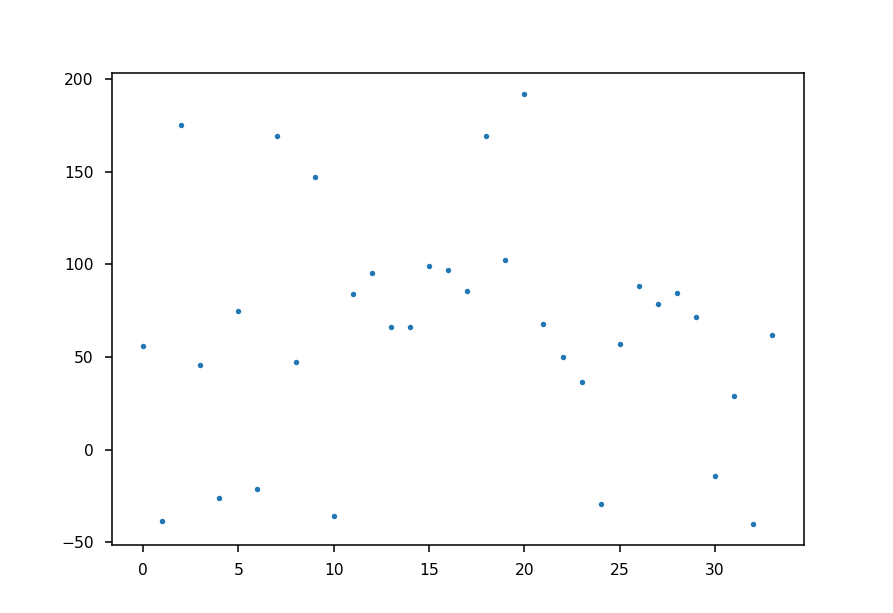

count     34.000000
mean      64.480820
std       62.604590
min      -40.071429
25%       38.956184
50%       66.982143
75%       93.590774
max      191.805556
dtype: float64

In [44]:
## Difference between DD PQL and ABS PQL
t2 = t
d = t2['bmdd QL']-t2['pe95 QL']

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(d.index, d, '.', clip_on=False)

display(d.describe())